This version of the example uses lmfit (https://lmfit.github.io/lmfit-py/) with an explicitly defined objective function

In [17]:
%pip install lmfit

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
from lmfit import minimize, Parameters
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [6]:
# Generate example data according to an exponential PDF
np.random.seed(42)
lambda_=3.14159   # lambda is a keyword, so use lambda_ instead!
x_true = np.random.exponential(scale=lambda_, size=1000)

# Create histogram of the data
range=(0.0,4.0)
counts, bin_edges = np.histogram(x_true, bins=50, range=range, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errs = np.sqrt(counts)

<ErrorbarContainer object of 3 artists>

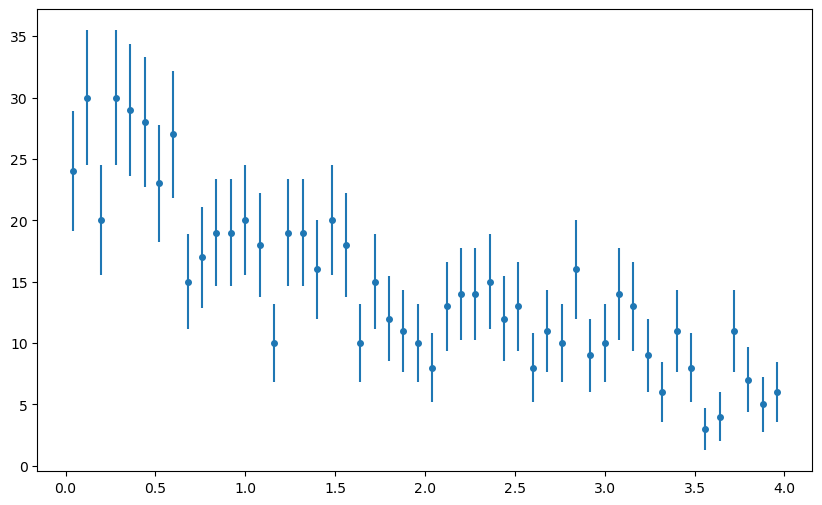

In [7]:
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=errs, fmt='o', label='Data', markersize=4)

In [11]:
def expo(x, scale, lambda_):
    return scale * np.exp(-x / lambda_)

def nll2_scalar(params, x, n):
    scale = params['scale'].value
    lambda_ = params['lambda_'].value
    mu = expo(x, scale, lambda_)
    mu = np.clip(mu, 1e-10, None)
    return 2.0 * np.sum(mu - n * np.log(mu) + gammaln(n + 1))

params = Parameters()
params.add('scale', value=np.max(counts))
params.add('lambda_', value=2.0)


Check our guess for the starting parameter values

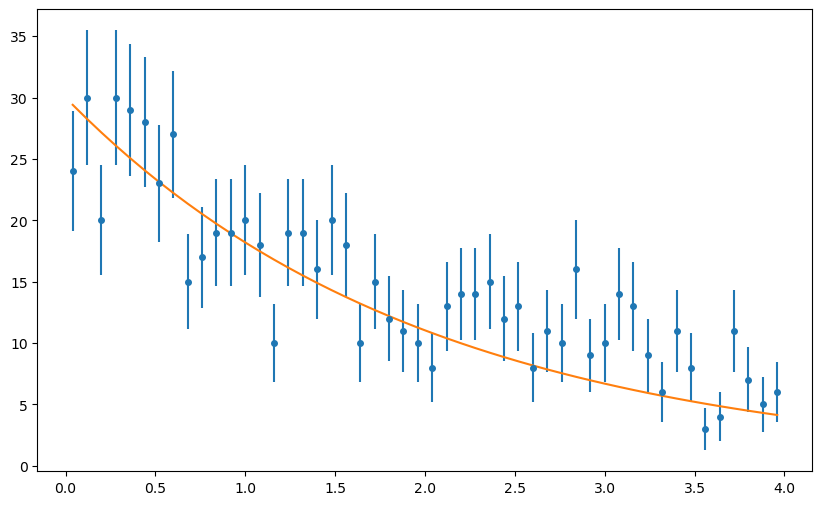

In [12]:
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=errs, fmt='o', label='Data', markersize=4)
plt.plot(bin_centers,expo(bin_centers,params['scale'].value,params['lambda_'].value))

The initial guess for the paraemter values looks pretty good.  Therfore the minimzer should be able to converge to a good minimum.

In [13]:
# Perform the fit (Poisson NLL)
result = minimize(nll2_scalar, params, args=(bin_centers, counts), method='nelder')

In [14]:
mu_hat = np.clip(expo(bin_centers,
                      result.params['scale'].value,
                      result.params['lambda_'].value), 1e-10, None)
two_nll = 2.0 * np.sum(mu_hat - counts * np.log(mu_hat) + gammaln(counts + 1))
two_nll

np.float64(261.4724999025205)


Fit Results:
scale: 27.1984
lambda_: 2.83699
2·NLL: 261.5
degrees of freedom: 48


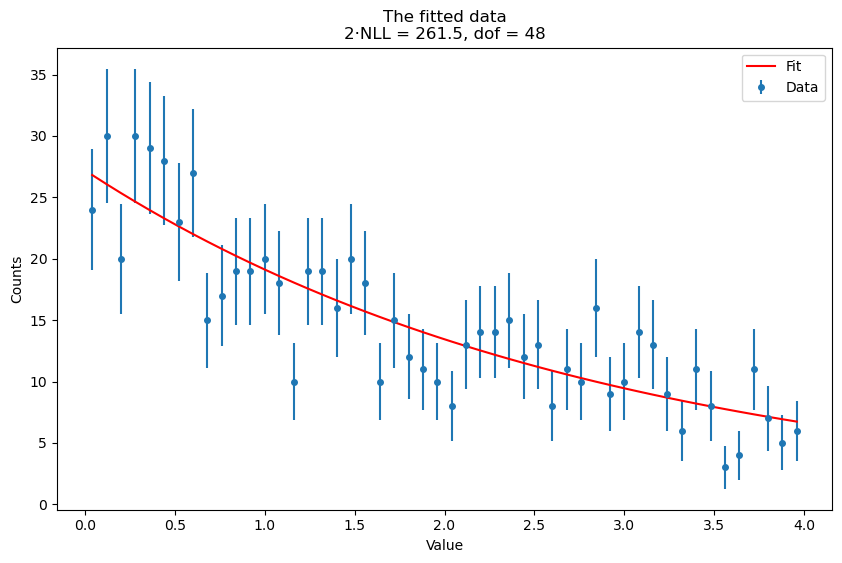

In [15]:
best_fit = expo(bin_centers, result.params['scale'].value, result.params['lambda_'].value)
mu_hat = np.clip(best_fit, 1e-10, None)
two_nll = 2.0 * np.sum(mu_hat - counts * np.log(mu_hat) + gammaln(counts + 1))
nDOF = len(counts) - 2

plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts),
             fmt='o', label='Data', markersize=4)
plt.plot(bin_centers, best_fit, 'r-', label='Fit')
plt.xlabel('Value'); plt.ylabel('Counts'); plt.legend()
plt.title('The fitted data\n' + f'2·NLL = {two_nll:.1f}, dof = {nDOF}')

print('\nFit Results:')
for name, param in result.params.items():
    print(f'{name}: {param.value:.6g}')
print(f'2·NLL: {two_nll:.1f}')
print(f'degrees of freedom: {nDOF}')
plt.show()


In [16]:
# using the internal fit report
from lmfit import fit_report
print(fit_report(result))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 80
    # data points      = 1
    # variables        = 2
    chi-square         = 68367.8682
    reduced chi-square = 68367.8682
    Akaike info crit   = 15.1326582
    Bayesian info crit = 11.1326582
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    scale:    27.1983689 (init = 30)
    lambda_:  2.83698551 (init = 2)


In [18]:
import uproot
from scipy.stats import chi2

with uproot.open("distros.root") as f:
    h1 = f["dist1"]
    counts1, edges1 = h1.to_numpy()

centers1 = 0.5 * (edges1[:-1] + edges1[1:])
mask1 = counts1 > 0
x1 = centers1[mask1]
n1 = counts1[mask1]

In [19]:
def two_gauss(x, a1, m1, s1, a2, m2, s2):
    return a1*np.exp(-0.5*((x - m1)/s1)**2) + a2*np.exp(-0.5*((x - m2)/s2)**2)

def gumbel_right(x, a, m, b):
    z = (x - m) / b
    return (a / b) * np.exp(-(z + np.exp(-z)))

def resid_two_gauss(p, x, n):
    a1 = p['a1'].value; m1 = p['m1'].value; s1 = p['s1'].value
    a2 = p['a2'].value; m2 = p['m2'].value; s2 = p['s2'].value
    mu = two_gauss(x, a1, m1, s1, a2, m2, s2)
    return (mu - n) / np.sqrt(n)

def resid_gumbel(p, x, n):
    a = p['a'].value; m = p['m'].value; b = p['b'].value
    mu = gumbel_right(x, a, m, b)
    return (mu - n) / np.sqrt(n)

i0 = int(np.argmax(n1))
m1_g = float(x1[i0]); a1_g = float(n1[i0])
far = np.abs(x1 - m1_g) > 0.1 * (x1.max() - x1.min())
j0 = int(np.argmax(np.where(far, n1, 0)))
m2_g = float(x1[j0]); a2_g = float(n1[j0])
s_g = 0.2 * (x1.max() - x1.min())
mbar = float((x1 * n1).sum() / n1.sum())
b_g = s_g

pg = Parameters()
pg.add('a1', value=a1_g, min=0)
pg.add('m1', value=m1_g)
pg.add('s1', value=max(s_g, 1e-6), min=1e-6)
pg.add('a2', value=a2_g, min=0)
pg.add('m2', value=m2_g)
pg.add('s2', value=max(s_g, 1e-6), min=1e-6)

pgum = Parameters()
pgum.add('a', value=n1.sum() / max(b_g, 1.0), min=0)
pgum.add('m', value=mbar)
pgum.add('b', value=max(b_g, 1e-6), min=1e-6)

r_gauss = minimize(resid_two_gauss, pg, args=(x1, n1), method='leastsq')
r_gumbel = minimize(resid_gumbel, pgum, args=(x1, n1), method='leastsq')


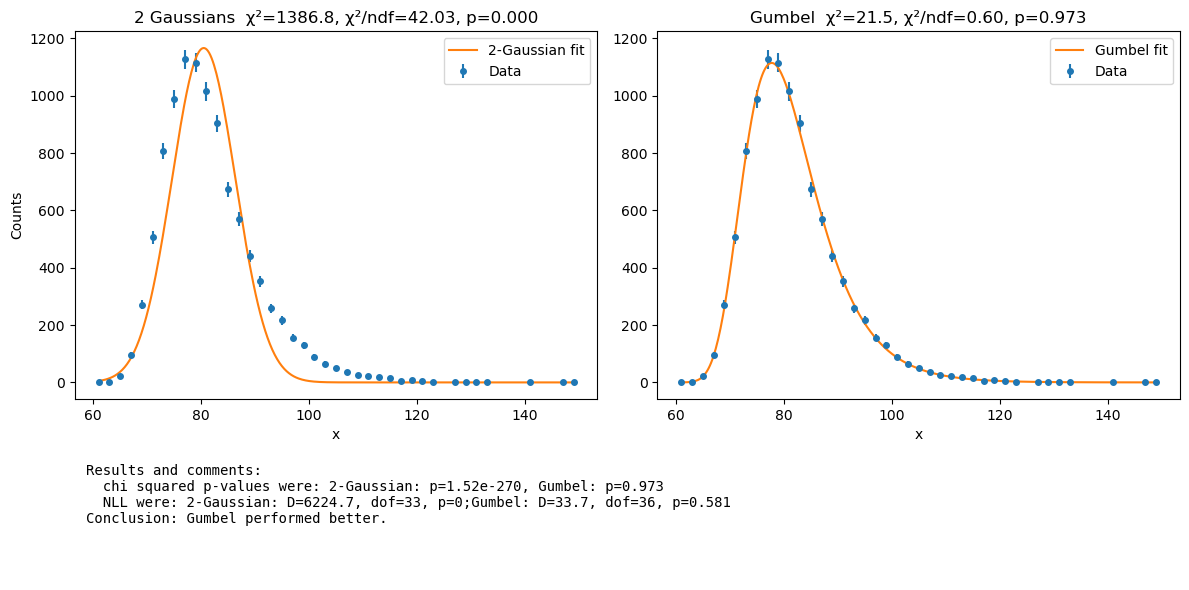

In [23]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

chi2_g = float(np.sum(r_gauss.residual**2))
ndf_g  = len(x1) - 6
pval_g = float(chi2.sf(chi2_g, ndf_g))

chi2_u = float(np.sum(r_gumbel.residual**2))
ndf_u  = len(x1) - 3
pval_u = float(chi2.sf(chi2_u, ndf_u))

mu_g = two_gauss(x1,
                 r_gauss.params['a1'].value, r_gauss.params['m1'].value, r_gauss.params['s1'].value,
                 r_gauss.params['a2'].value, r_gauss.params['m2'].value, r_gauss.params['s2'].value)
mu_u = gumbel_right(x1,
                    r_gumbel.params['a'].value, r_gumbel.params['m'].value, r_gumbel.params['b'].value)

with np.errstate(divide='ignore', invalid='ignore'):
    term_g = np.where(n1 > 0, mu_g - n1 + n1 * np.log(n1 / mu_g), mu_g)
    term_u = np.where(n1 > 0, mu_u - n1 + n1 * np.log(n1 / mu_u), mu_u)
D_g = 2.0 * np.sum(term_g);  pdev_g = float(chi2.sf(D_g, ndf_g))
D_u = 2.0 * np.sum(term_u);  pdev_u = float(chi2.sf(D_u, ndf_u))

xgrid = np.linspace(x1.min(), x1.max(), 400)
fit_gauss  = two_gauss(xgrid,
                       r_gauss.params['a1'].value, r_gauss.params['m1'].value, r_gauss.params['s1'].value,
                       r_gauss.params['a2'].value, r_gauss.params['m2'].value, r_gauss.params['s2'].value)
fit_gumbel = gumbel_right(xgrid,
                          r_gumbel.params['a'].value, r_gumbel.params['m'].value, r_gumbel.params['b'].value)

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[3, 1], figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(x1, n1, yerr=np.sqrt(n1), fmt='o', label='Data', markersize=4)
ax1.plot(xgrid, fit_gauss, label='2-Gaussian fit')
ax1.set_title(f'2 Gaussians  χ²={chi2_g:.1f}, χ²/ndf={chi2_g/ndf_g:.2f}, p={pval_g:.3f}')
ax1.set_xlabel('x'); ax1.set_ylabel('Counts'); ax1.legend()

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.errorbar(x1, n1, yerr=np.sqrt(n1), fmt='o', label='Data', markersize=4)
ax2.plot(xgrid, fit_gumbel, label='Gumbel fit')
ax2.set_title(f'Gumbel  χ²={chi2_u:.1f}, χ²/ndf={chi2_u/ndf_u:.2f}, p={pval_u:.3f}')
ax2.set_xlabel('x'); ax2.legend()

ax3 = fig.add_subplot(gs[1, :]); ax3.axis('off')
text = (
    "Results and comments:\n"
    f"  chi squared p-values were: 2-Gaussian: p={pval_g:.3g}, Gumbel: p={pval_u:.3g}\n"
    f"  NLL were: 2-Gaussian: D={D_g:.1f}, dof={ndf_g}, p={pdev_g:.3g};"
    f"Gumbel: D={D_u:.1f}, dof={ndf_u}, p={pdev_u:.3g}\n"
    "Conclusion: Gumbel performed better."
)
ax3.text(0.01, 0.95, text, va='top', family='monospace')

fig.tight_layout()
fig.savefig("ex1.pdf", bbox_inches='tight')
plt.show()
